# BA 820 Homework 2

Group Name:A8

Member Names: Wenxuan Yan, Ziyuan Li, Yen-Chun Chen, Ziyin Chen, Yicheng Jiang

Reminder: you should not be sharing code across groups

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [4]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [5]:
########################################################################
######################### Write your code here #########################
########################################################################
import glob
docs = []
for file in glob.glob("./data/enron/*.txt"):
    docs.append(make_word_list(file))

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [6]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=50, stop_words="english", max_df=0.8)
X = vectorizer.fit_transform(docs).toarray()

### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [7]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.mixture import GaussianMixture
import numpy as np
X = vectorizer.fit_transform(docs)
gmm = GaussianMixture(n_components=3)
gmm.fit(X.toarray())
labels = gmm.predict(X.toarray())

# Count the number of lists in each cluster
unique_labels, counts = np.unique(labels, return_counts=True)

for i, count in zip(unique_labels, counts):
    print("Cluster", i, "has", count)


Cluster 0 has 4402
Cluster 1 has 404
Cluster 2 has 365


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [8]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

In [9]:
########################################################################
######################### Write your code here #########################
########################################################################
vocabulary = vectorizer.vocabulary_
# Select 3 "spammy" words
spammy_words = ['click', 'www', 'offer']
spam_indices = [vocabulary[word] for word in spammy_words if word in vocabulary]
print(spam_indices)

[238, 1670, 998]


In [10]:
hammy_words = ['meeting', 'attached', 'review']
ham_indices = [vocabulary[word] for word in hammy_words if word in vocabulary]
print(ham_indices)

[904, 108, 1283]


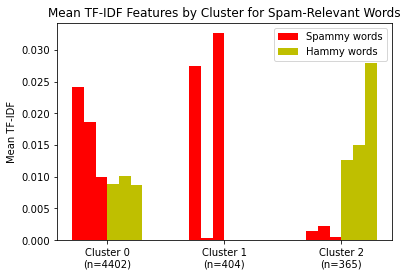

In [11]:
import matplotlib.pyplot as plt
predicted = gmm.predict(X.toarray())
n_clusters = 3
plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices)

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

*** WRITE YOUR ANSWER HERE IN TEXT ***

According to the graph in part (d), the first cluster corresponds to spam emails, based on the frequency of spammy and hammy words. The second cluster corresponds to typical spam emails, since it consist most with spamy words. The third cluster corresponds to typical business emails.

But when we change the number of clusters to 5, the second, fourth and fifth clearly appear to spam email. The first one is half and half and the third one has slightly more spam than ham.
If we change clusters to 2, both cluster consist some spam or ham.
Thus it is better have more clusters.

Cluster 0 has 654
Cluster 1 has 412
Cluster 2 has 3839
Cluster 3 has 76
Cluster 4 has 190


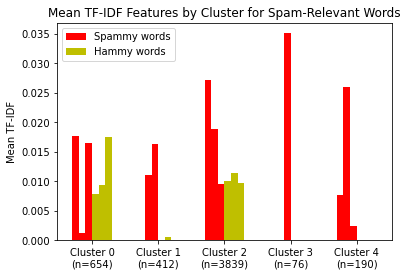

In [13]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.mixture import GaussianMixture
import numpy as np
X = vectorizer.fit_transform(docs)
gmm1 = GaussianMixture(n_components=5)
gmm1.fit(X.toarray())
labels = gmm1.predict(X.toarray())

# Count the number of lists in each cluster
unique_labels, counts = np.unique(labels, return_counts=True)

for i, count in zip(unique_labels, counts):
    print("Cluster", i, "has", count)

########################################################################
import matplotlib.pyplot as plt
predicted = gmm1.predict(X.toarray())
n_clusters = 5
plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices)

Cluster 0 has 2700
Cluster 1 has 2471


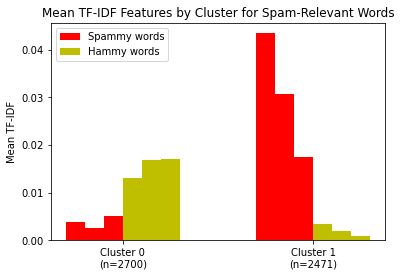

In [29]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.mixture import GaussianMixture
import numpy as np
X = vectorizer.fit_transform(docs)
gmm2 = GaussianMixture(n_components=2)
gmm2.fit(X.toarray())
labels = gmm2.predict(X.toarray())

# Count the number of lists in each cluster
unique_labels, counts = np.unique(labels, return_counts=True)

for i, count in zip(unique_labels, counts):
    print("Cluster", i, "has", count)

########################################################################
import matplotlib.pyplot as plt
predicted = gmm2.predict(X.toarray())
n_clusters = 2
plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices)

## Question 2: Latent "Purposes" in Mobile Apps [50 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [16]:
df = pd.read_csv("/Users/davidyan/Downloads/android.csv", sep=",",  thousands=",")

In [17]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [18]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [26]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
#del df # uncomment to free up RAM
#del df_perms # uncomment to free up RAM

### Part C: Downweight "stopwords" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [27]:
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.feature_extraction.text import TfidfTransformer
X_tfidf = TfidfTransformer().fit_transform(X)

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [33]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 10
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10,
                            
                                n_jobs=-1, random_state=314159265)
lda.fit(X_tfidf)

CPU times: user 4.12 s, sys: 222 ms, total: 4.34 s
Wall time: 24 s


LatentDirichletAllocation(n_jobs=-1, random_state=314159265)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [34]:
########################################################################
######################### Write your code here #########################
########################################################################
n_top_words = 10
feature_names = permission_columns
most_probable_words = []
for topic_idx, topic in enumerate(lda.components_):
    topic_normalized = topic / topic.sum()
    message = "Topic #%d: " % topic_idx
    message += "\n\t"
    message += "\n\t".join([feature_names[i] + ' -- prob: %f' % topic_normalized[i]
                            for i in topic_normalized.argsort()[:-n_top_words-1:-1]])
    most_probable_words.append("\n\t".join([feature_names[i]
                                            for i in topic.argsort()[:-n_top_words-1:-1]]))
    print(message)
    print()

Topic #0: 
	Phone calls : read phone state and identity (D) -- prob: 0.167220
	Your personal information : read contact data (D) -- prob: 0.098742
	System tools : retrieve running applications (D) -- prob: 0.075982
	Network communication : full Internet access (D) -- prob: 0.074215
	Services that cost you money : send SMS messages (D) -- prob: 0.068777
	Your accounts : discover known accounts (S) -- prob: 0.053768
	Your messages : receive SMS (D) -- prob: 0.051375
	Network communication : view network state (S) -- prob: 0.047457
	Services that cost you money : directly call phone numbers (D) -- prob: 0.032160
	Your messages : read SMS or MMS (D) -- prob: 0.031877

Topic #1: 
	Storage : modify/delete USB storage contents modify/delete SD card contents (D) -- prob: 0.281158
	System tools : prevent device from sleeping (D) -- prob: 0.265795
	Network communication : full Internet access (D) -- prob: 0.152792
	Phone calls : read phone state and identity (D) -- prob: 0.101385
	Network commun

*** WRITE YOUR ANSWER HERE IN TEXT ***

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [35]:
########################################################################
######################### Write your code here #########################
########################################################################
topic_proportions = lda.transform(X_tfidf)
for i in range(10):
    idx = np.argsort(topic_proportions[:,i])[::-1]
    selected = app_ratings > 100000
    print("Topic #" + str(i) + ":")
    counter = 10
    for app_idx in idx:
        if counter <= 0:
            break
        if selected[app_idx] == False:
            continue
        app = app_names[app_idx]
        print("\t" + app + ' -- proportion in topic %d: %f' % (i, topic_proportions[app_idx, i]))
        counter -= 1
    print()

Topic #0:
	Zynga Poker -- proportion in topic 0: 0.754239
	TuneIn Radio -- proportion in topic 0: 0.743409
	Horoscope -- proportion in topic 0: 0.601595
	chompSMS -- proportion in topic 0: 0.579055
	Backgrounds HD Wallpapers -- proportion in topic 0: 0.553880
	Tap Fish -- proportion in topic 0: 0.552785
	Ringdroid -- proportion in topic 0: 0.424947
	Words With Friends Free -- proportion in topic 0: 0.411301
	GO SMS Pro -- proportion in topic 0: 0.385223
	Facebook for Android -- proportion in topic 0: 0.385072

Topic #1:
	Real BlackJack -- proportion in topic 1: 0.716376
	Paradise Island -- proportion in topic 1: 0.696195
	World Newspapers -- proportion in topic 1: 0.696195
	My Country -- proportion in topic 1: 0.696195
	Robo Defense FREE -- proportion in topic 1: 0.625119
	Restaurant Story??? -- proportion in topic 1: 0.593102
	Restaurant Story™ -- proportion in topic 1: 0.593102
	SpeechSynthesis Data Installer -- proportion in topic 1: 0.549957
	Tank Hero -- proportion in topic 1: 0.4

### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [15 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000


/Users/davidyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.395397
[t-SNE] KL divergence after 1000 iterations: -0.332679


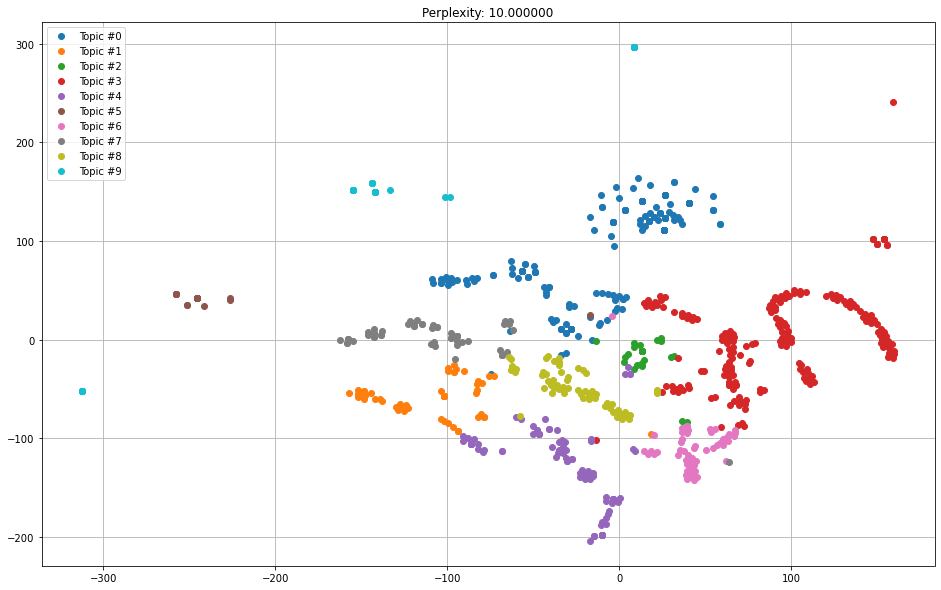

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000


/Users/davidyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.007679
[t-SNE] KL divergence after 1000 iterations: -0.324475


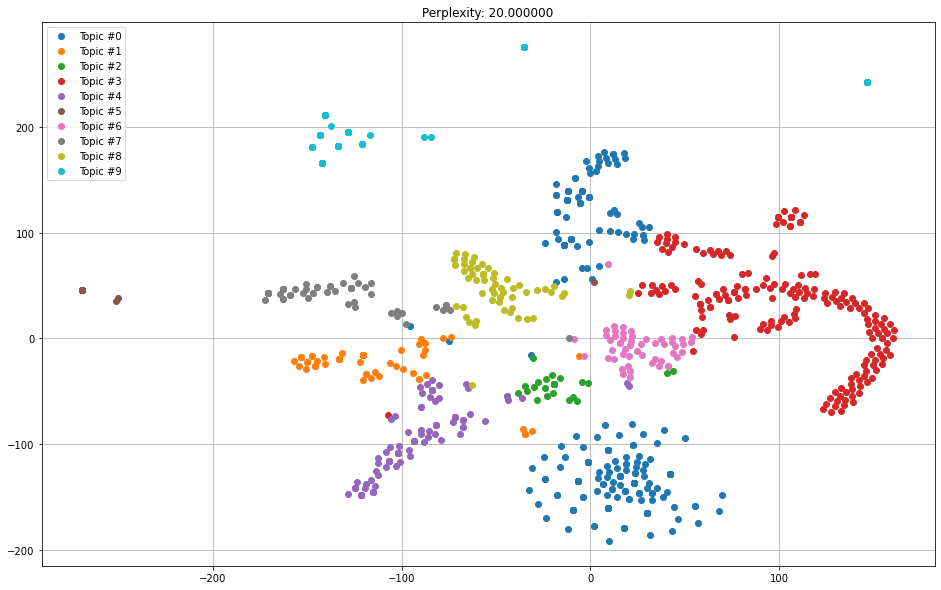

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000


/Users/davidyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.424156
[t-SNE] KL divergence after 1000 iterations: -0.696003


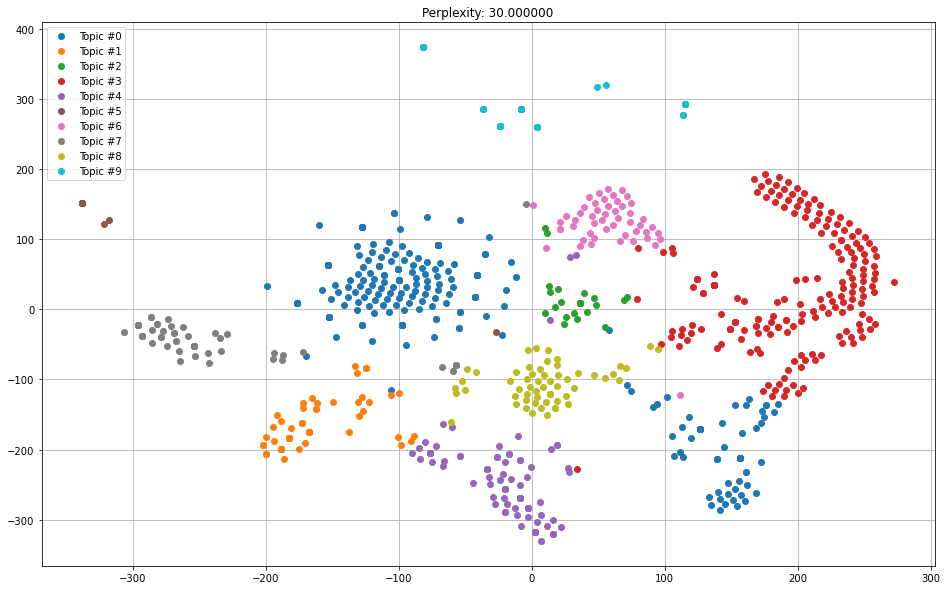

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000


/Users/davidyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.398506
[t-SNE] KL divergence after 1000 iterations: -0.880006


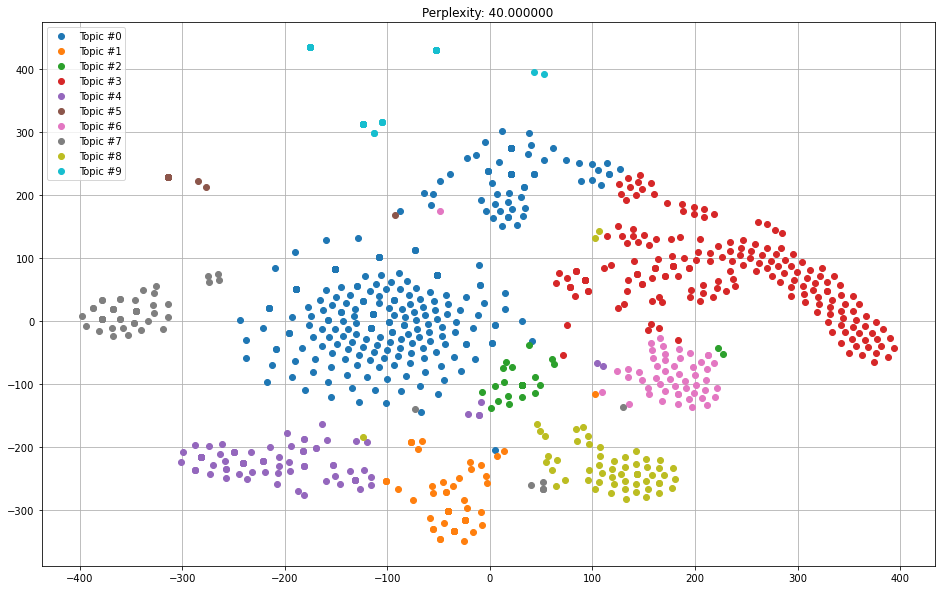

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000


/Users/davidyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.743340
[t-SNE] KL divergence after 1000 iterations: -0.827802


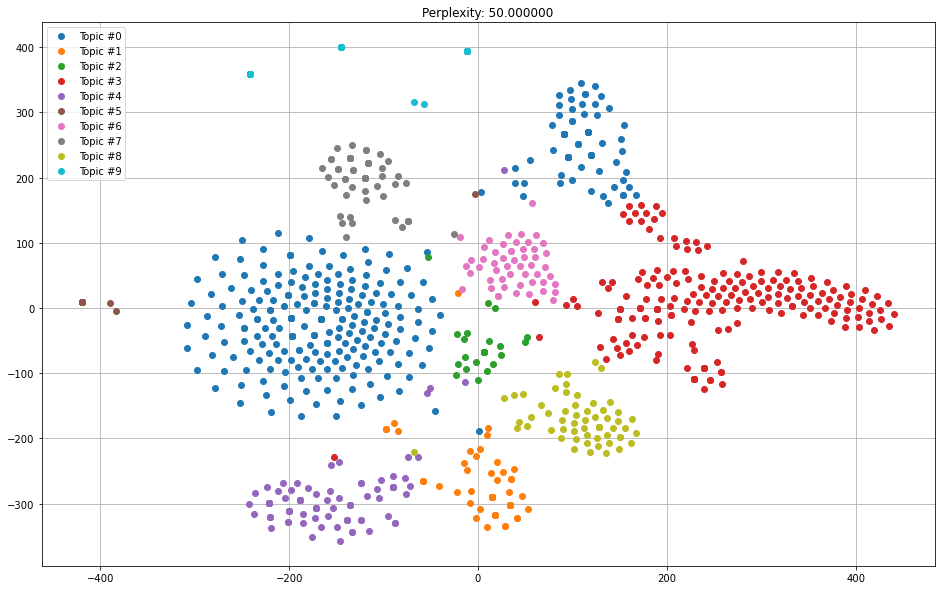

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000


/Users/davidyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.370274
[t-SNE] KL divergence after 1000 iterations: -0.776110


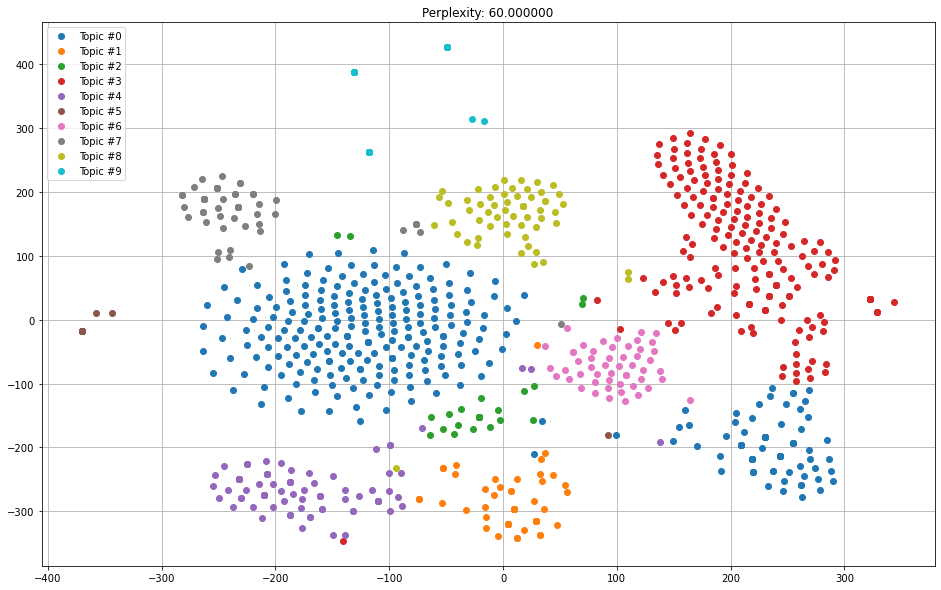

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000


/Users/davidyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.983009
[t-SNE] KL divergence after 1000 iterations: -0.834491


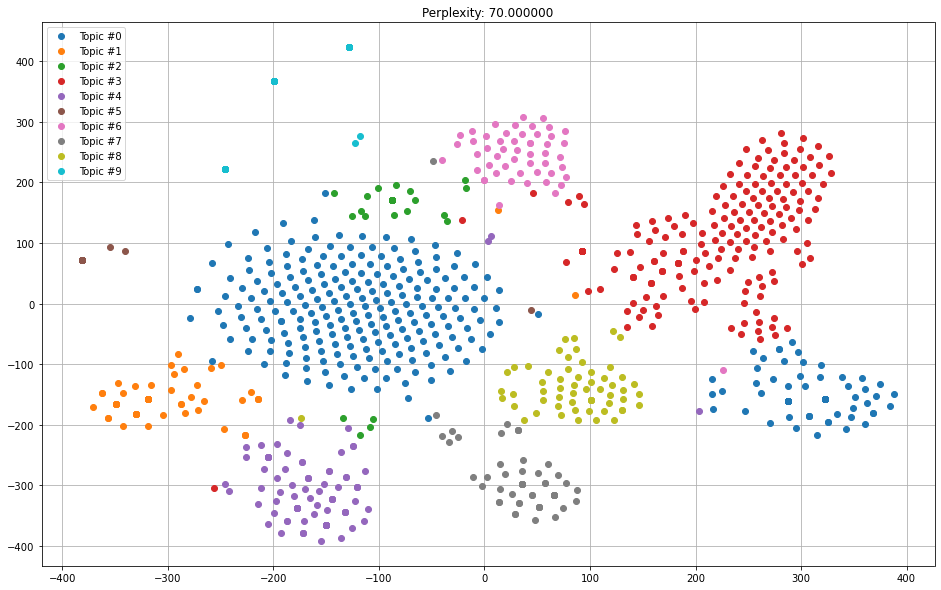

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000


/Users/davidyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.283516
[t-SNE] KL divergence after 1000 iterations: -0.530608


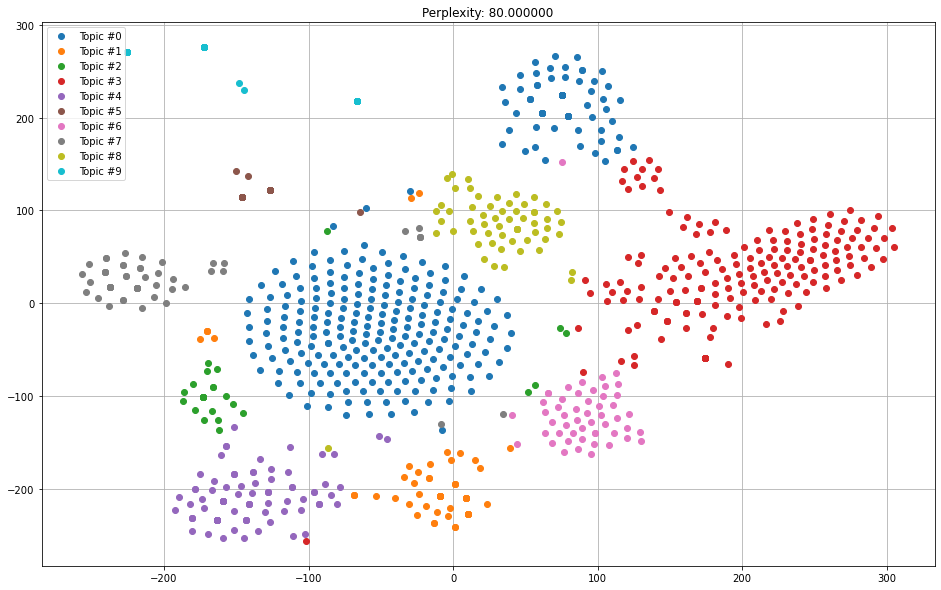

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000


/Users/davidyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.235970
[t-SNE] KL divergence after 1000 iterations: 0.052614


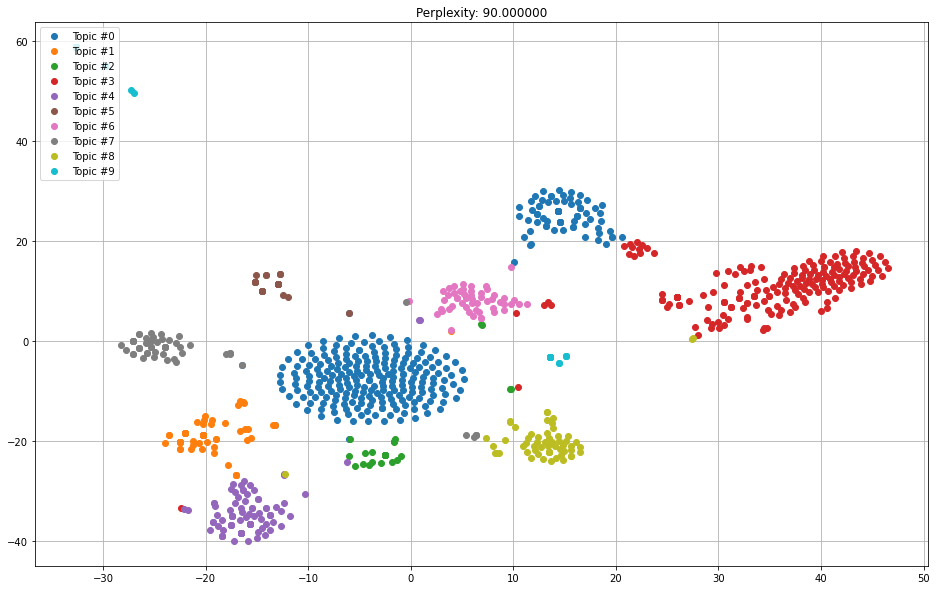

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000


/Users/davidyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.848415
[t-SNE] KL divergence after 1000 iterations: 0.127072


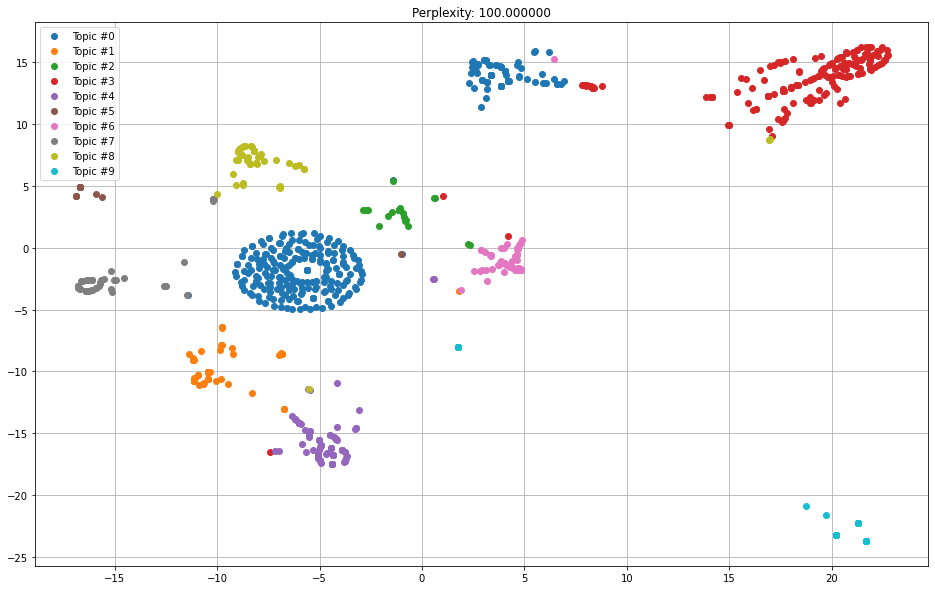

[t-SNE] Computing 999 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.061s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1125899906842624.000000


/Users/davidyan/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 36.915993
[t-SNE] KL divergence after 1000 iterations: -0.064404


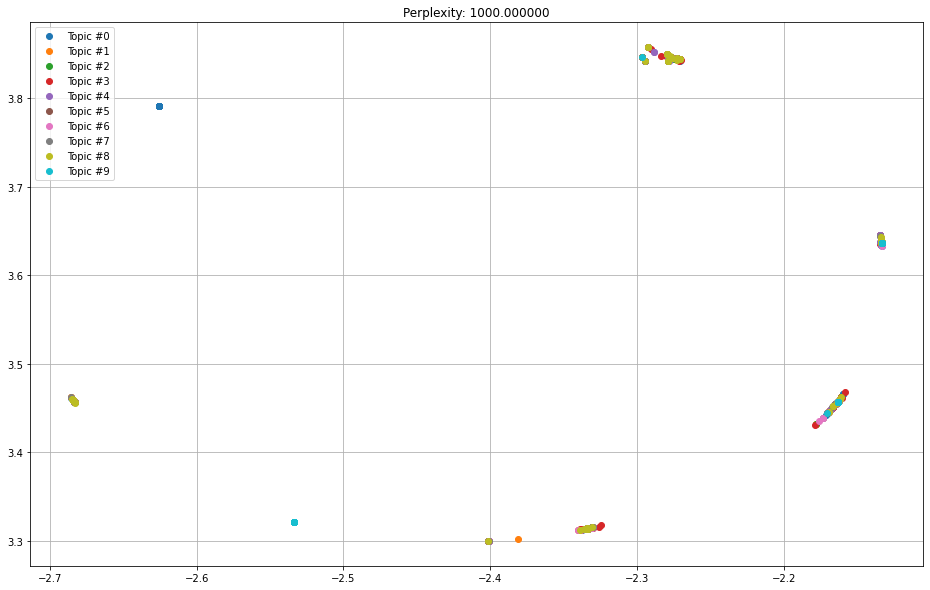

CPU times: user 2min 45s, sys: 27.9 s, total: 3min 13s
Wall time: 26.4 s


In [36]:
%%time
########################################################################
######################### Write your code here #########################
########################################################################
from sklearn.manifold import TSNE

for perplexity in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 1000]:
    tsne_model = TSNE(n_components=2, learning_rate=800, perplexity=perplexity,
                      verbose=1, random_state=0, angle=.5, init='pca')
    topic_tsne_lda = tsne_model.fit_transform(topic_proportions[:1000,:])

    plt.figure(figsize=(16,10))
    most_probable_topic = np.argmax(topic_proportions, axis=1)[:1000]
    for t in range(10):
        plt.plot(topic_tsne_lda[most_probable_topic==t,0], topic_tsne_lda[most_probable_topic==t,1], 'o',
                 label="Topic #" + str(t))
    plt.legend(loc='upper left')
    plt.title('Perplexity: %f' % perplexity)
    plt.grid()
    plt.show()